In [1]:
!pip install scipy==1.8.0
!pip install texttable


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import networkx as nx
import matplotlib.pyplot as plt
from itertools import product
import statistics
import numpy as np
import math
import collections
import scipy
from scipy.spatial import distance
from texttable import Texttable

In [17]:
NUM_OF_GRAPHS = 10
NUM_OF_NODES = 100

# Creating Graphs

In [4]:
def create_random_graph(n=100, p=0.04):
    return nx.erdos_renyi_graph(n, p)


def create_small_world_ws_graph(n=100, p=0.35, m=4):
    return nx.watts_strogatz_graph(n, m, p)


def create_small_world_nws_graph(n=100, p=0.35, k=4):
    return nx.newman_watts_strogatz_graph(n, k, p)


def create_agave_graph(n=100, steps=1):
    G = nx.Graph()
    G.add_nodes_from([x for x in range(n)])
    if steps < 0:
        steps = 0
    elif steps >= n:
        steps = n-1;
    for i in range(steps+1):
        for j in range(i+1, n):
            G.add_edge(i,j)
    return G


def create_scale_free_graph(n=100, gamma=2):
    seq = nx.utils.powerlaw_sequence(n, gamma) #100 nodes, power-law exponent 2.5
    G = nx.expected_degree_graph(seq, selfloops=False)
    return G

# Read and Write to File

In [5]:
def write_list_to_file(file_name, floats):
    with open(("outputs/" + file_name), "w") as f:
        f.write("\n".join(map(str, floats)))
        
def read_list_from_file(file_name):
    with open("outputs/" + file_name, "r") as f:
        content = f.read()
        floats = list(map(float, content.split()))
    return floats

# Main Functions

In [6]:
def get_average_degree(G):
    return sum(G.degree(v) for v in G.nodes()) / G.number_of_nodes()

In [7]:
def get_average_path_length(G):
    connected_components = (G.subgraph(c) for c in nx.connected_components(G))
    average_paths = []
    for component in connected_components:
        average_paths.append(nx.average_shortest_path_length(component))
    return statistics.mean(average_paths)

In [8]:
def get_propagation_ratio(K, n, L=6):
    # n = G.number_of_nodes()
    # K = get_average_degree(G)
    return n / math.pow(K,L)
    

def get_Cp_analytic(K, rewiring):
    # K = get_average_degree(G)
    p = rewiring
    return (3*K-6)/(4*K-2)*((1-p)**3)


def get_Fx(x):
    return 1/(2*math.sqrt((x**2)+(2*x)))*np.arctanh(math.sqrt(x/(x+2)))


def get_Lp(K, rewiring, n):
    # n = G.number_of_nodes()
    # K = get_average_degree(G)
    p = rewiring
    return 2*n/K*get_Fx(n*K*p/2)

In [9]:
# Rn is the number of available paths from i_0 to i_n with distinct nodes
def calculate_Rn(n, adjacency_matrix, i_0, i_n):
    # indices = [range(len(adjacency_matrix)) for x in range(n-1)]
    s = 0
    if n == 2:
        for a in range(len(adjacency_matrix)):
            if adjacency_matrix[i_0][a] and adjacency_matrix[a][i_n]:
                s += 1
    if n == 3:
        for a in range(len(adjacency_matrix)):
            for b in range(a+1, len(adjacency_matrix)):
                if adjacency_matrix[i_0][a] and adjacency_matrix[a][b] and adjacency_matrix[b][i_n]:
                    s += 1
    elif n == 4:
        for a in range(len(adjacency_matrix)):
            for b in range(a+1, len(adjacency_matrix)):
                for c in range(b+1, len(adjacency_matrix)):
                    if adjacency_matrix[i_0][a] and adjacency_matrix[a][b] and adjacency_matrix[b][c] and adjacency_matrix[c][i_n]:
                        s += 1
    elif n == 5:
        for a in range(len(adjacency_matrix)):
            for b in range(a+1, len(adjacency_matrix)):
                for c in range(b+1, len(adjacency_matrix)):
                    for d in range(c+1, len(adjacency_matrix)):
                        if adjacency_matrix[i_0][a] and adjacency_matrix[a][b] and adjacency_matrix[b][c] and adjacency_matrix[c][d] and adjacency_matrix[d][i_n]:
                            s += 1
    elif n == 6:
        for a in range(len(adjacency_matrix)):
            for b in range(a+1, len(adjacency_matrix)):
                for c in range(b+1, len(adjacency_matrix)):
                    for d in range(c+1, len(adjacency_matrix)):
                        for e in range(d+1, len(adjacency_matrix)):
                            if adjacency_matrix[i_0][a] and adjacency_matrix[a][b] and adjacency_matrix[b][c] and adjacency_matrix[c][d] and adjacency_matrix[d][e] and adjacency_matrix[e][i_n]:
                                s += 1
    return s


def get_Cp(G):
    adjacency_matrix = nx.adjacency_matrix(G).toarray()
    Rn = [[x] for x in list(G)]
    sumds = [0]
    sumns = []
    cycle_nodes = []
    for i in range(1,6):
        Rn_new = []
        sumn = 0
        cycle_nodes.append(set([]))
        for path in Rn:
            for neighbor in list(G[path[-1]]):
                if neighbor in path[1:]:
                    continue
                if neighbor == path[0]:
                    sumn += 1
                    for node in path:
                        cycle_nodes[i-1].add(node)
                else:
                    Rn_new.append(path + [neighbor])
        Rn = Rn_new
        sumd = len(Rn_new)
        sumns.append(sumn)
        sumds.append(sumd)
        # sumds[i-1] += sumn
    #C6
    sumn = 0
    cycle_nodes.append(set([]))
    for path in Rn:
        if path[0] in G[path[-1]]:
            sumn += 1
            for node in path:
                cycle_nodes[5].add(node)
    sumns.append(sumn)
    # sumds[5] += sumn

    Cps = []
    for i in range(3,7):
        Cps.append(sumns[i-1]/sumds[i-1])
    return Cps, sumds[2:], sumns[2:], cycle_nodes[2:]


def calculate_Sq_old(G, q):
    adjacency_matrix = nx.adjacency_matrix(G).toarray()
    sum_numerator = 0
    sum_denominator = 0
    for i in range(len(adjacency_matrix)):
        for j in range(i, len(adjacency_matrix)):
            if i == j:
                sum_numerator += calculate_Rn(q, adjacency_matrix, i, i)
            else:
                sum_denominator += calculate_Rn(q-1, adjacency_matrix, i, j)
    return sum_numerator, sum_denominator


def get_Cp_old(G, p):
    sum_numerator, sum_denominator = calculate_Sq_old(G,q)
    return sum_numerator/(sum_denominator+sum_numerator)

In [10]:
def get_degree_variance(G):
    return statistics.variance([x[1] for x in list(G.degree())])


def get_degree_entropy(G):
    degree_sequence = sorted([d for n, d in G.degree()])  # degree sequence
    degrees = collections.Counter(degree_sequence)
    sum_degrees = sum(degrees.values())
    return (-1) * sum((degrees[k] * math.log(degrees[k]/sum_degrees)) for k in degrees) / sum_degrees

In [11]:
def get_rn_and_tn(n, G):
    adjacency_matrix = nx.adjacency_matrix(G).toarray()
    np_matrix = np.array(adjacency_matrix)
    new_matrix = np_matrix
    rns = []
    tns = []
    rn = np.count_nonzero(new_matrix) / (len(adjacency_matrix)**2)
    rns.append(rn)
    tns.append(rn)
    for i in range(1,n):
        new_matrix = np.matmul(new_matrix, np_matrix)
        rn = np.count_nonzero(new_matrix) / (len(adjacency_matrix)**2)
        rns.append(rn)
        tns.append(rn + tns[i-1])
    return rns, tns

In [12]:
def get_regression_line(x, y):
    b, a = np.polyfit(x, y, deg=1)
    xnp = np.array(x)
    linenp = a + b * xnp
    return linenp.tolist()

In [13]:
def get_hamming_coeff(G):
    adjacency_matrix = nx.adjacency_matrix(G).toarray()
    hsum = 0
    n = len(adjacency_matrix)
    for i in range(n):
        for j in range(i+1, n):
            hsum += sum([adjacency_matrix[i][x]*adjacency_matrix[j][x] for x in range(n)])
            # for x in range(n):
            #     hsum += adjacency_matrix[i][x]*adjacency_matrix[j][x]
            # sumh += sum(a * b for a,b in zip(adjacency_matrix[i], adjacency_matrix[j]))
            # sumh += distance.hamming(adjacency_matrix[i], adjacency_matrix[j]) * G.number_of_nodes()
    h = hsum * 2 / (n * (n-1))
    return h

In [14]:
def get_graph_entropy(G):
    A = nx.adjacency_matrix(G)
    erdos = nx.from_numpy_matrix(A.todense())
    q_E = 0
    edges = list(erdos.edges())
    for i in range(len(edges)):
        d1 = erdos.degree(edges[i][0])
        d2 = erdos.degree(edges[i][1])
        q_E = q_E + (1/d1) + (1/d2) - (2/ math.sqrt(d1*d2))
    #print("q_E",q_E)
    Q_E_3 = q_E / (n - 2 * math.sqrt(n-1))
    # Quantum_Entropy.append(Q_E_3)
    return Q_E_3

def get_graph_energy(G):
    A = nx.adjacency_matrix(G)
    erdos = nx.from_numpy_matrix(A.todense())

    n = nx.number_of_nodes(erdos)
    m = nx.number_of_edges(erdos)
    eig_matrix = np.abs(nx.adjacency_spectrum(erdos))

    #################### Energy #############################
    E_G = np.sum(np.abs(nx.adjacency_spectrum(erdos)))
    #print("Energy: ",E_G)

    # Energy_laplacian
    ba = erdos.copy()
    n = ba.number_of_nodes()
    m = ba.number_of_edges() * 2
    eig_lap = nx.laplacian_spectrum(ba)
    E_G_L = np.sum(np.abs(eig_lap - m/float(n)))
    #print("Energy laplacian: ",E_G_L)

    # Energy_index_safaei
    E = abs(E_G - E_G_L)
    Energy = E / max(E_G,E_G_L)
    return Energy

# n, Cp, average path, R

In [18]:
ns = [x for x in range(50, 1001, 50)]
# nns = [x for x in range(1,11)]
# qs = [3,4,5,6]
# cs = [[] for x in range(len(qs))]
# ss = [[] for x in range(len(qs))]
# rns = [[] for x in range(len(nns))]
# tns = [[] for x in range(len(nns))]
# cycles = [[] for x in range(len(qs))]
# cycle_nodes = [[] for x in range(len(qs))]
# graphs = []
# ds = []
# rs = []
hcsr = []
hcssw = []
hcssf = []
vsr = []
vssw = []
vssf = []
esr = []
essw = []
essf = []
for n in ns:
    # csums = [0 for x in range(len(qs))]
    # ssums = [0 for x in range(len(qs))]
    # tsums = [0 for x in range(len(nns))]
    # rsums = [0 for x in range(len(nns))]
    # cycles_sums = [0 for x in range(len(qs))]
    # dsum = 0
    # rsum = 0
    hcsumr = 0
    hcsumsw = 0
    hcsumsf = 0
    vsumr = 0
    vsumsw = 0
    vsumsf = 0
    esumr = 0
    esumsw = 0
    esumsf = 0
    print(n)
    for j in range(NUM_OF_GRAPHS):
        Gr = create_random_graph(n)
        Gsw = create_small_world_ws_graph(n, 0.35)
        Gsf = create_scale_free_graph(n)
        # cps, sps, cycles_temp, cns_temp = get_Cp(G)
        # if (n == ns[-1]):
            # graphs.append(G)
        # rns_temp, tns_temp = get_rn_and_tn(n, G)
        # dsum += get_average_path_length(G)
        # rsum += get_propagation_ratio(4,n)
        vsumr += get_degree_variance(Gr)
        vsumsw += get_degree_variance(Gsw)
        vsumsf += get_degree_variance(Gsf)
        esumr += get_degree_entropy(Gr)
        esumsw += get_degree_entropy(Gsw)
        esumsf += get_degree_entropy(Gsf)
        hcsumr += get_hamming_coeff(Gr)
        hcsumsw += get_hamming_coeff(Gsw)
        hcsumsf += get_hamming_coeff(Gsf)
        # for i in range(len(qs)):
        #     csums[i] += cps[i]
        #     ssums[i] += sps[i]
        #     cycles_sums[i] += cycles_temp[i] / ((i+3)*2)
        #     if (n == ns[-1]):
        #         cycle_nodes[i].append(cns_temp[i])
        # for i in range(len(nns)):
        #     tsums[i] += tns_temp[i]
        #     rsums[i] += rns_temp[i]
    # for i in range(len(qs)):
    #     cs[i].append(csums[i]/NUM_OF_GRAPHS)
    #     ss[i].append(ssums[i]/NUM_OF_GRAPHS)
    #     cycles[i].append(cycles_sums[i]/NUM_OF_GRAPHS)
    # for i in range(len(nns)):
    #     rns[i].append(rsums[i]/NUM_OF_GRAPHS)
    #     tns[i].append(tsums[i]/NUM_OF_GRAPHS)
    # ds.append(dsum/NUM_OF_GRAPHS)
    # rs.append(rsum/NUM_OF_GRAPHS)
    vsr.append(vsumr/NUM_OF_GRAPHS)
    vssw.append(vsumsw/NUM_OF_GRAPHS)
    vssf.append(vsumsf/NUM_OF_GRAPHS)
    esr.append(esumr/NUM_OF_GRAPHS)
    essw.append(esumsw/NUM_OF_GRAPHS)
    essf.append(esumsf/NUM_OF_GRAPHS)
    hcsr.append(hcsumr/NUM_OF_GRAPHS)
    hcssw.append(hcsumsw/NUM_OF_GRAPHS)
    hcssf.append(hcsumsf/NUM_OF_GRAPHS)

50


C:\Users\WebVajhegan\AppData\Local\Temp\ipykernel_21448\3136095869.py:2: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency_matrix = nx.adjacency_matrix(G).toarray()


100
150
200
250
300
350
400
450
500
550
600
650
700
750


KeyboardInterrupt: 

# degree variace - n

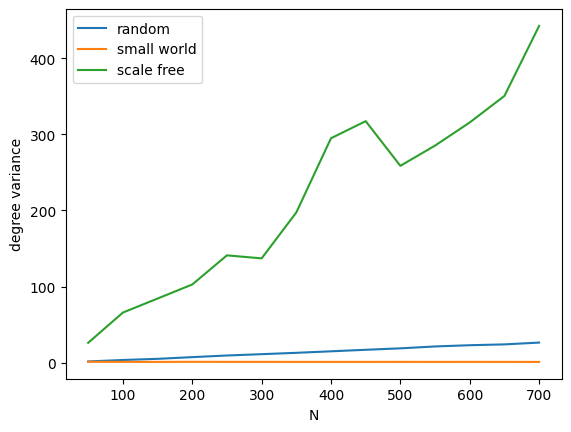

In [19]:
ns = [x for x in range(50, 750, 50)]
plt.plot(ns, vsr, label='random')
plt.plot(ns, vssw, label='small world')
plt.plot(ns, vssf, label='scale free')
plt.xlabel('N')
plt.ylabel('degree variance')
plt.legend()

# degree entropy - n

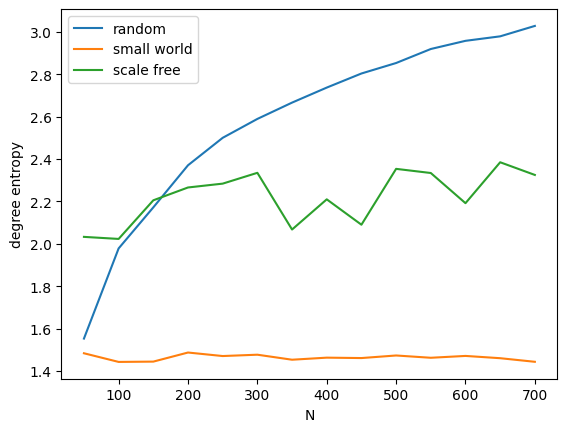

In [20]:
plt.plot(ns, esr, label='random')
plt.plot(ns, essw, label='small world')
plt.plot(ns, essf, label='scale free')
plt.xlabel('N')
plt.ylabel('degree entropy')
plt.legend()

# Multiplicity and Hamming Coefficient

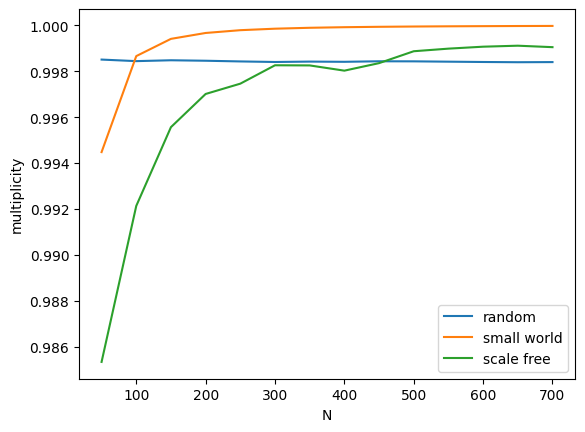

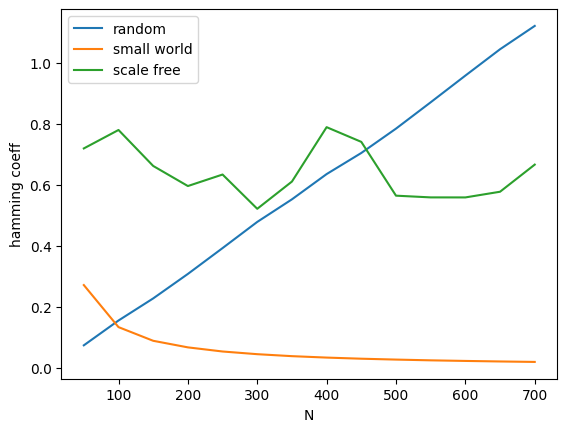

In [21]:
plt.plot(ns, 1-(np.array(hcsr)*(1/(np.array(ns)-1))), label='random')
plt.plot(ns, 1-(np.array(hcssw)*(1/(np.array(ns)-1))), label='small world')
plt.plot(ns, 1-(np.array(hcssf)*(1/(np.array(ns)-1))), label = 'scale free')
plt.xlabel('N')
plt.ylabel('multiplicity')
plt.legend()
plt.show()
plt.plot(ns, hcsr, label='random')
plt.plot(ns, hcssw, label='small world')
plt.plot(ns, hcssf, label='scale free')
plt.xlabel('N')
plt.ylabel('hamming coeff')
plt.legend()